### Meta-connectivity

Analysis of the global meta-connectivity

In [1]:
# Adding GDa to path
import os
import sys

sys.path.insert(1, "/home/vinicius/storage1/projects/GrayData-Analysis")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from tqdm import tqdm

from GDa.graphics import plot
from GDa.net.static import _modularity
from GDa.util import _extract_roi

#### Define functions to compute trimmer strengths

In [2]:
def trimmer_strengths(meta_conn, n_nodes=None):
    """Given a MC matrix it computes the trimmer strengths for each node"""
    # ROIs
    roi_s, roi_t = _extract_roi(meta_conn.sources.values, "-")
    # Unique ROIs
    rois = np.unique(np.stack((roi_s, roi_t)))
    # Get the number of nodes
    n_nodes = len(rois)
    # Store trimmer-strengths for each node
    ts = np.zeros(n_nodes)
    for i in range(n_nodes):
        # Get indexes where node i is present
        idx = np.logical_or(roi_s == rois[i], roi_t == rois[i])
        # Get sub-matrix only with meta-edges containing i
        sub_mat = meta_conn.values[np.ix_(idx, idx)]
        ts[i] = np.triu(sub_mat, 1).sum(axis=(0, 1))
    ts = xr.DataArray(ts, dims="roi", coords={"roi": rois})
    return ts

#### Plotting and file saving configurations

In [3]:
SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE = plot.set_plot_config()

In [4]:
_ROOT = os.path.expanduser("~/funcog/gda")
_RESULTS = "Results/lucy/meta_conn"
_FILE = os.path.join(_ROOT, _RESULTS, f"MC_coh_global.nc")

In [5]:
MC = xr.load_dataarray(_FILE)

#### Detecting communities in the MC matrix

In [6]:
MC.attrs["aff"] = np.zeros((MC.shape[0], MC.shape[-1]))
MC.attrs["Q"] = np.zeros(MC.shape[-1])

for i in tqdm(range(MC.shape[-1])):
    aff, Q = _modularity(A=MC.isel(freqs=i).values, backend="brainconn")
    MC.attrs["aff"][:, i] = aff
    MC.attrs["Q"][i] = Q

100%|████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.72it/s]


#### Computing within module trimmer-strength

In [7]:
TS = {}
for f in tqdm(range(MC.shape[-1])):
    TS[f] = {}
    affiliation_vector = MC.attrs["aff"][:, f]
    for aff in np.unique(affiliation_vector):
        idx = affiliation_vector == aff
        TS[f][aff] = trimmer_strengths(MC[..., f][idx, idx])

100%|████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 41.26it/s]


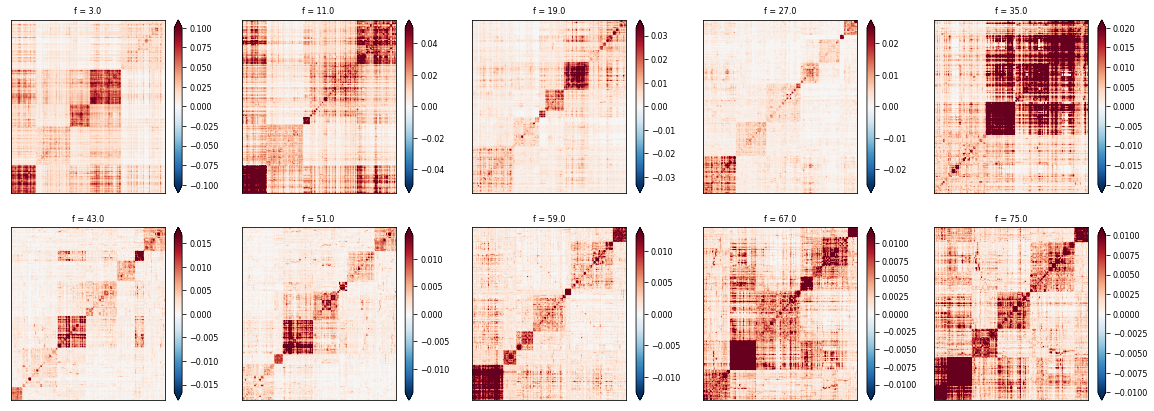

In [8]:
plt.figure(figsize=(20, 7))
for i in range(10):
    av, q = _modularity(A=MC.isel(freqs=i).values, backend="brainconn")
    idx = np.argsort(av)
    plt.subplot(2, 5, i + 1)
    plt.imshow(
        MC.isel(freqs=i).values[np.ix_(idx, idx)],
        aspect="auto",
        cmap="RdBu_r",
        vmin=-0.1 / (i + 1),
        vmax=0.1 / (i + 1),
        origin="lower",
    )
    plt.colorbar(extend="both")
    plt.xticks([])
    plt.yticks([])
    plt.title(f"f = {MC.freqs.values[i]}")

#### Converting to DataFrame

In [9]:
TS_df = []
for f in TS.keys():
    for aff in TS[f].keys():
        out = TS[f][aff].to_dataframe("TS").reset_index()
        out["aff"] = [aff] * len(out)
        out["f"] = [MC.freqs.values[f]] * len(out)
        TS_df += [out]

TS_df = pd.concat(TS_df)

In [10]:
df = []
for f in range(MC.shape[-1]):
    ts = TS[f]
    x_s, x_t = _extract_roi(MC.isel(freqs=f).sources.values, "-")
    aff = MC.attrs["aff"][..., f]
    freqs = [MC.freqs.values[f]] * len(x_s)
    df += [
        pd.DataFrame(
            np.stack((x_s, x_t, freqs, aff)).T, columns=["from", "to", "f", "aff"]
        )
    ]

df = pd.concat(df)

In [11]:
TS_df.to_csv("data/timmer_strength_global.csv")
df.to_csv("data/meta_conn_global.csv")

#### Flatmaps of Trimmer-strength

In [30]:
from GDa.flatmap.flatmap import flatmap

In [53]:
def plot_flatmap(data, vmin=None, vmax=None, annotation=None, fig_name=None):

    """Plot the flatmaps of MC for a given frequency"""
    # Define sub-cortical areas names
    sca = np.array(["thal", "putamen", "claustrum", "caudate"])

    # Get number of communities
    n_comm = len(data.keys())

    # Create canvas in which the flatmaps will be drawn
    fig = plt.figure(figsize=(8, 4), dpi=600)
    gs1 = fig.add_gridspec(
        nrows=1, ncols=n_comm, left=0.05, right=0.87, bottom=0.05, top=0.92
    )
    # Will store the axes of the figure
    ax = []
    count = 0
    for c in range(n_comm):
        # Get area names
        areas = data[c + 1].roi.values
        areas = [a.lower() for a in areas]
        index = np.where(np.isin(areas, sca))
        _areas_nosca = np.delete(areas, index)
        # Flatmap axis
        ax += [plt.subplot(gs1[count])]
        # Get values to plot in the flatmap
        values = data[c + 1].values
        # Delete values for subcortical areas
        values = np.delete(values, index)
        # Instantiate flatmap
        fmap = flatmap(values, _areas_nosca)
        # Only plot colorbar for last column
        fmap.plot(
            ax[count],
            vmin=None,
            vmax=None,
            alpha=0.6,
            colormap="hot_r",
        )
        count += 1
        if c == 0 and isinstance(annotation, (int, float)):
            plt.annotate(f"{annotation} Hz", (0, 0.2), fontsize=5)
    if isinstance(fig_name, str):
        plt.savefig(fig_name)
        plt.close()

In [54]:
for f in range(10):
    plot_flatmap(TS[f], annotation=MC.freqs.values[f], fig_name=f"temp/ts_flatmaps_{f}.png")

#### Plotting meta-connectivity network communities

In [54]:
library(ggraph)
library(ggpubr)
library(igraph)
library(tidyverse)
library(repr)
library(RColorBrewer)

In [55]:
df = read.csv("data/meta_conn_global.csv")
ts = read.csv("data/timmer_strength_global.csv")

In [56]:
create_graph <- function(freqs, community_number) {
    # Filter frequency and time of interest
    idx = (df$f == freqs)
    # Filter the data-frame
    df_filt <- df[idx, ]
    # Create network
    edges <- df_filt[, c(2,3,5)]
    # Order nodes
    edges <- edges[order(edges$from),]
    # Create a graph object
    graph <- igraph::graph_from_data_frame( d=edges, directed=F )
    # Node strength
    strengths <- igraph::degree(graph = graph)
    
    # Get roi names
    rois <- unique(c(as.character(edges$from), as.character(edges$to)))
    n_rois <- length(rois)
    
    # Compute nodes size base on TS
    idx_ts <- (ts$f == freqs) & (ts$aff == community_number)
    ts_filt <- ts[idx_ts, ]
    
    node_sizes <- rep(0, n_rois)
    i <- 1
    for(roi in rois) {
        if(roi %in% ts_filt$roi) {
            node_sizes[i] <- ts_filt[ts_filt$roi==roi, ]$TS
        } else {
            node_sizes[i] <- 0
        }
        i <- i + 1
    }
    
    # Filter edges belonging to a given community
    filter <- (edges$aff == community_number)

    if(sum(edges$aff == community_number) == 0) {
        df <- data.frame()
        p <- ggplot(df) + geom_point() + xlim(0, 10) + ylim(0, 100) + theme_void()
    }
    else {
        # Create plot
        p <- ggraph(graph, layout = 'linear', circular = TRUE) + 
                    geom_edge_arc(aes(filter = filter),
                                  show.legend=F) +
                    geom_node_point(aes(x = x*1.07, y=y*1.07, size=node_sizes),
                                    color="blue",
                                    alpha=0.6, show.legend=F) +
                    geom_node_text(aes(label=rois, x=x*1.15, y=y*1.15),
                                   color="black",
                                   size=2, alpha=1, show.legend=F) +
                    theme_void() +
                    ggtitle("") +
                    ylab("") +
                    theme(
                      plot.title = element_text(hjust = 0.5, size=10),
                      plot.margin=unit(c(0,0,0,0),"cm"),
                    ) 
    }
    return (p)
}

In [ ]:
options(repr.plot.width=10, repr.plot.height=10)
create_graph(35, 2)

In [ ]:
count <- 1

freqs <- unique(df$f)
myplots <- vector('list', length(freqs) * 9)
i <- 1

for(f in freqs) {
  for(a in 1:9) {
    p1 <- create_graph(f, a)
    myplots[[i]] <- local({
      i <- i
      print(p1)
    })
    i <- i + 1
  }
}

In [68]:
labels = c(
    "3 Hz",
    "",
    "",
    "",
    "",
    "",
    "",
    "",
    "",
    "11 Hz",
    "",
    "",
    "",
    "",
    "",
    "",
    "",
    "",
    "19 Hz",
    "",
    "",
    "",
    "",
    "",
    "",
    "",
    "",
    "27 Hz",
    "",
    "",
    "",
    "",
    "",
    "",
    "",
    "",
    "35 Hz",
    "",
    "",
    "",
    "",
    "",
    "",
    "",
    "",
    "43 Hz",
    "",
    "",
    "",
    "",
    "",
    "",
    "",
    "",
    "51 Hz",
    "",
    "",
    "",
    "",
    "",
    "",
    "",
    "",
    "59 Hz",
    "",
    "",
    "",
    "",
    "",
    "",
    "",
    "",
    "67 Hz",
    "",
    "",
    "",
    "",
    "",
    "",
    "",
    "",
    "75 Hz",
    "",
    "",
    "",
    "",
    "",
    "",
    "",
    "",
)

plot < -ggarrange(plotlist=myplots, ncol=9, nrow=length(freqs), labels=labels)

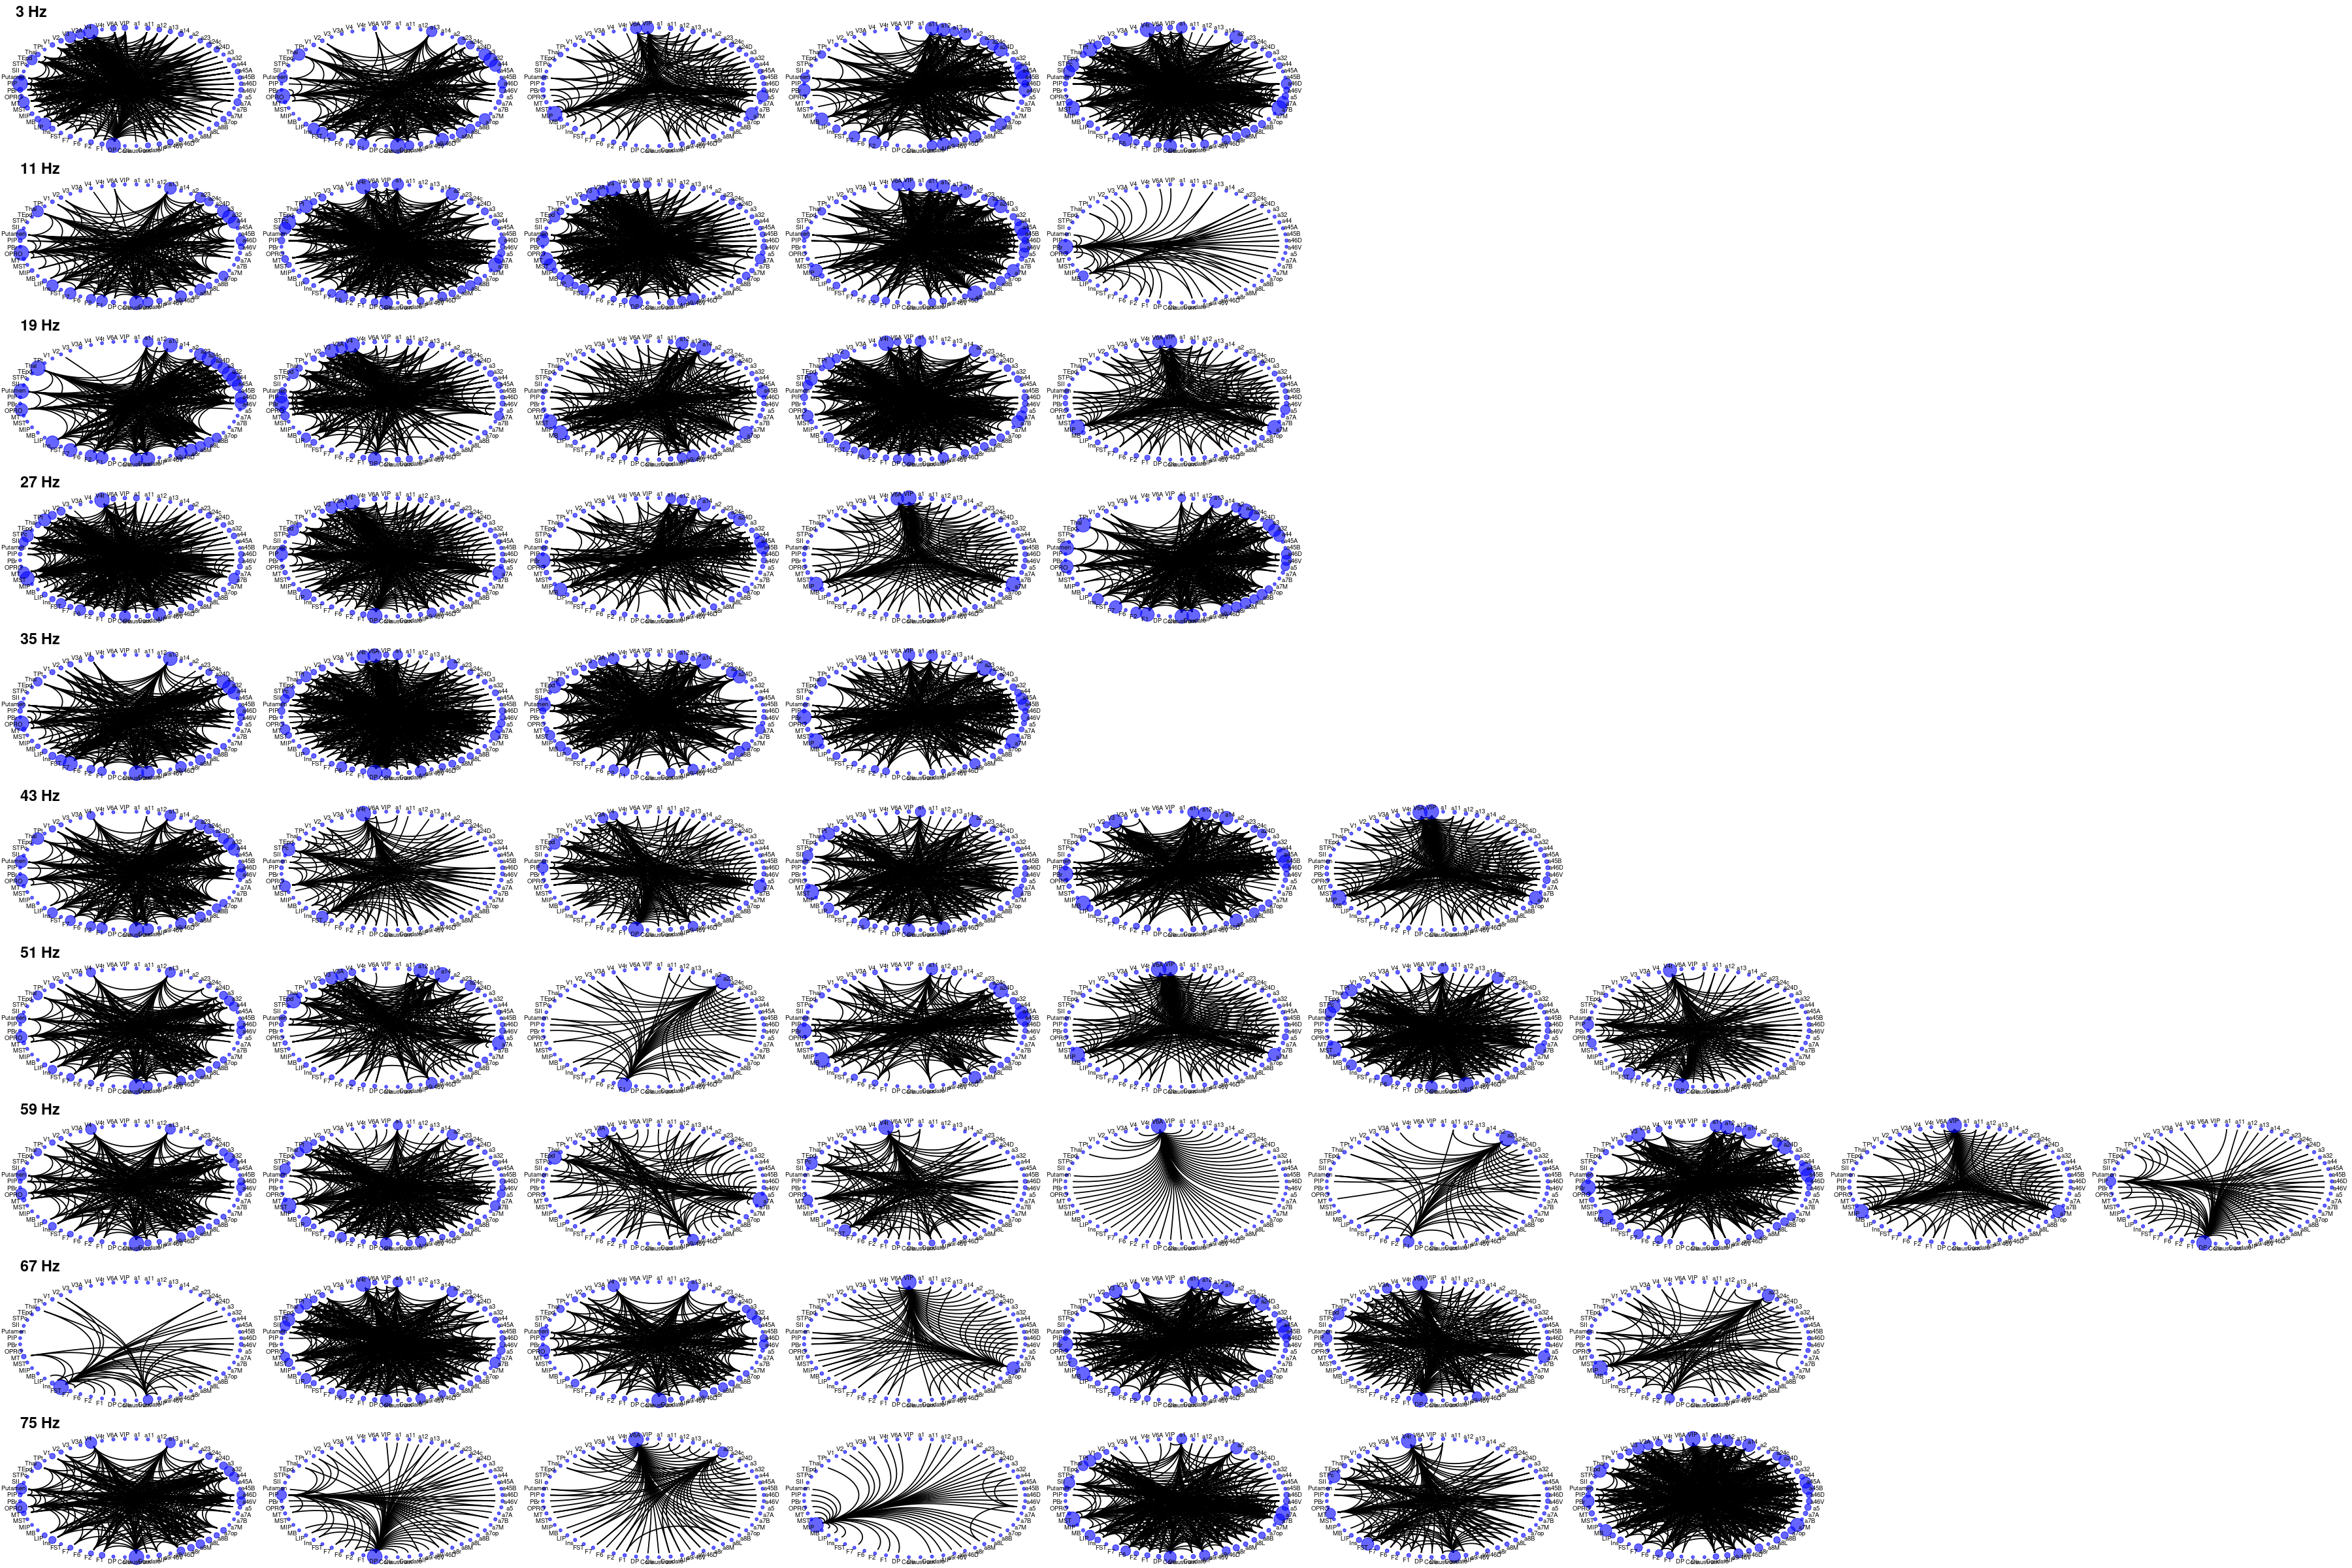

In [69]:
options(repr.plot.width=30, repr.plot.height=20)
plot

In [70]:
ggsave("MC_modules_ts.pdf", width=30, height=20)